(c) 2019 [Thomas Wiecki](https://twitter.com/twiecki) & [Ravin Kumar](https://twitter.com/canyon289)

One big problem I often observe with data science is that it often falls short of having a true impact on the bottom line of the business. The reasons for this are manifold but I firmly believe that Bayesian modeling solves many of them. Two highlight just two:

* Bayesian statistics allows us to include all prior information we have about the structure of the problem into the model so that we don't have to learn *everything* from data like with Machine Learning.
* Because our models map the actual business problem, we can interpret their outputs much more readily and communicate them to stakeholders.

However, there still is a gap when it comes to having these outputs (posterior distributions) actually have an impact. You might be quite pleased with yourself when you give your manager not just a point-estimate for how much budget they should allocate but instead a posterior distribution, but when they make their budget allocation decision, they still need to input just a single number.

The solution to this problem, and one we often use for [client projects](https://www.pymc-labs.io/clients/) at [PyMC Labs](https://www.pymc-labs.io), is to also model the decision making process and incorporate the model estimate directly into that. In brief, by defining a loss function that maps business decisions to outcomes we can use an optimizer to find the best decision(s) not only under the *most likely scenario*, but under *all plausible scenarios*. This not only moves Bayesian modeling from something that informs a decision to something that *makes* a decision, it also allows you - the modeler - to communicate your results in the only language business cares about:

<img src="https://media.giphy.com/media/uFtywzELtkFzi/giphy.gif"/>

In this blog post we want to demonstrate this powerful method with a the general problem of **supply chain optimization**, an area where Bayesian statistics can have a big impact.

In [1]:
%matplotlib inline

import pymc3 as pm
import theano.tensor as tt
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import arviz as az
import matplotlib.pyplot as plt

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

## Supply chain optimization to operate a spaceport

It is the year 12119 (under our [new Human Era](https://www.youtube.com/watch?v=czgOWmtGVGs) calendar), humanity has become a space-faring civilization. Bayesians and Frequentists still argue about which statistics are better. You are a Data Scientist at a spaceport called PyMC-X (why did you think we have a rocket for our logo?) that sends humans to the moon, Mars, Europa, and the ISS 5.0 in Saturn's orbit. You are tasked with managing the supply chain to keep the rockets running.

While the rockets themselves are reusable, we need a new rocket engine for every launch. There are three suppliers we can order engines from. These suppliers have different prices, different yields (i.e. how many of their shipped engines are functional), and different maximum order amounts. While we know the prices and order sizes, the true yield we do not know and can only estimate from past orders. However, as we will use simulated data here, we will include the unobservable parameters `SUPPLIER_YIELD` and `SUPPLIER_YIELD_SD`. In reality we would not have access to this information.

In [2]:
SUPPLIER_YIELD = np.array([.9, .5, .8]) # unknown
SUPPLIER_YIELD_SD = np.array([.1, .2, .2]) # unknown
PRICES = [220.0, 100.0, 120.0] # known
MAX_ORDER_SIZE = [100, 80, 100] # known

The yield represents the percentage of engines that pass our stress tests (a faulty engine lead to the [abort of the Space Shuttle launch STS-93](https://www.youtube.com/watch?v=T7vGqQUhciE) so this is an actual problem). Due to different manufacturing techniques, the yield varies quite a bit by supplier, which is also reflected in the price. As don't know the true yield, we will have to estimate it from previous batches we ordered. In our example, we have ordered more times from certain suppliers than others. For example, as supplier 2 (third list item) only opened up recently, we only ordered twice from there:

In [3]:
N_OBS = [30, 20, 2]

In [4]:
np.random.seed(100)
data = []
for supplier_yield, supplier_yield_sd, n_obs in zip(SUPPLIER_YIELD, SUPPLIER_YIELD_SD, N_OBS):
    data.append(pm.Beta.dist(mu=supplier_yield, sd=supplier_yield_sd, shape=n_obs).random())
    
data

[array([0.978235  , 0.98946102, 0.99035051, 0.83762708, 0.66130327,
        0.98785994, 0.85327018, 0.8500779 , 0.99913878, 0.89881072,
        0.8175994 , 0.95181804, 0.91545214, 0.87137954, 0.96166603,
        0.99033823, 0.96319861, 0.94124979, 0.96555922, 0.96606356,
        0.92723444, 0.97736913, 0.86764773, 0.81749131, 0.98597604,
        0.97980665, 0.77295709, 0.9584931 , 0.88875261, 0.99585613]),
 array([0.51788973, 0.67831661, 0.64888304, 0.61595363, 0.08634205,
        0.72543455, 0.51883833, 0.5454235 , 0.30357696, 0.21743938,
        0.54628383, 0.68559965, 0.28827533, 0.79246239, 0.65810975,
        0.69059483, 0.59297579, 0.85482231, 0.38115298, 0.8296909 ]),
 array([0.89241857, 0.9000698 ])]

/Users/twiecki/miniconda3/envs/pymc3theano/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


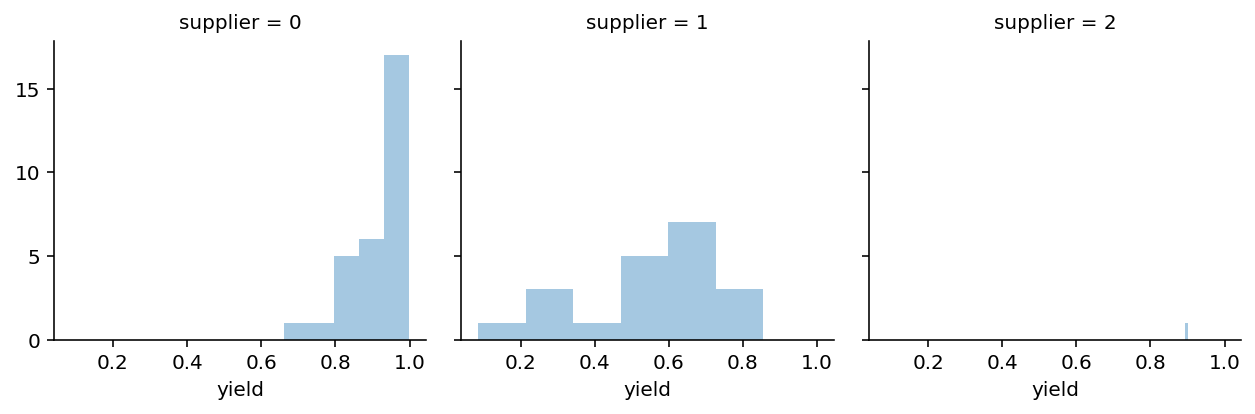

In [5]:
data_df = pd.DataFrame(data).T
data_tidy = data_df.unstack().to_frame('yield')
data_tidy.index = data_tidy.index.set_names(['supplier', 'obs'])
g = sns.FacetGrid(data=data_tidy.reset_index().dropna(), col='supplier')
g.map(sns.distplot, 'yield', kde=False);

So this is the data we have available to try and estimate the true yield of every supplier.

## Quick note on the generality of this problem

We mainly choose the spaceport example in a scifi setting because it's fun, but the underlying problem is very general and the solution widely applicable. Almost every retailer (like Amazon) has this problem of deciding how much to order given yield and holding cost. A similar problem also occurs in insurance where you need to sell contracts which have some risk of becoming claims. Or in online advertising where you need to decide how much to bid on clicks given a budget. Even if you don't work on these industries, the cost of any inefficiencies gets passed onto you, the customer! We also had a similar problem at [Quantopian](https://www.quantopian.com) when deciding which algorithms to select in our fund and how much capital to deploy to each one. OK, back to optimizing the supply chain at PyMC-X!

## The dynamics of operating a spaceport

In order to assess how many engines we need we first need to know how many rocket launches we can sell. If we buy too few we are leaving money on the table, if we buy too many we will have to put them in storage which costs money (`HOLDING_COST`). Let's assume we can sell a rocket for 500 bitcoins (BTC) and it costs us 100 BTC in holding cost.

In [6]:
SALES_PRICE = 500 
HOLDING_COST = 100

Next, let's define our loss function which takes as inputs how many engines we have in stock, how many launches customers want, at what price we bought the engine, at what price we can sell the launch, and what the holding costs are per engine:

In [7]:
@np.vectorize
def loss(in_stock, demand, buy_price, sales_price=SALES_PRICE, holding_cost=HOLDING_COST):
    # How much do we earn per launch
    margin = sales_price - buy_price
    # Do we have more in stock than demanded?
    if in_stock > demand:
        total_profit = demand * margin
        # everything left over after demand was met goes into holding
        total_holding_cost = (in_stock - demand) * holding_cost
        reward = total_profit - total_holding_cost
    else:
        # Can only sell what we have in stock, no storage required
        reward = in_stock * margin
    
    # Usually we minimize, so invert
    return -reward

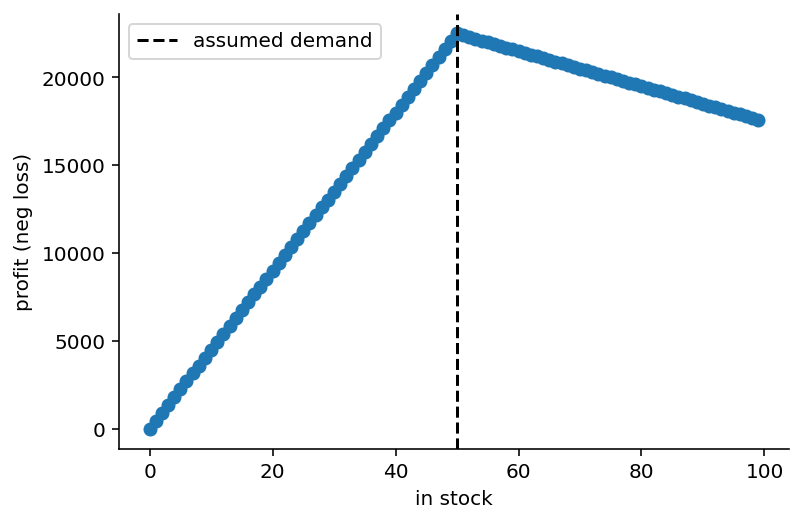

In [8]:
in_stock = np.arange(0, 100)
plt.scatter(in_stock, -loss(in_stock, 50, 50)); plt.axvline(50, c='k', ls='--', label='assumed demand');
plt.xlabel('in stock'); plt.ylabel('profit (neg loss)'); sns.despine(); plt.legend();

As you can see, if customer demand is 50 launches, we maximize our profit if we have 50 engines in stock. Having fewer engines eats into our profits at a greater rate than ordering excess engines because in this setup our margins are larger than the holding cost.

Next, we need our estimate of demand. As we have a long history of launches we have a pretty good idea of what the distribution looks like, but we will also assume that we don't know the true underlying parameters and only have access to the samples:

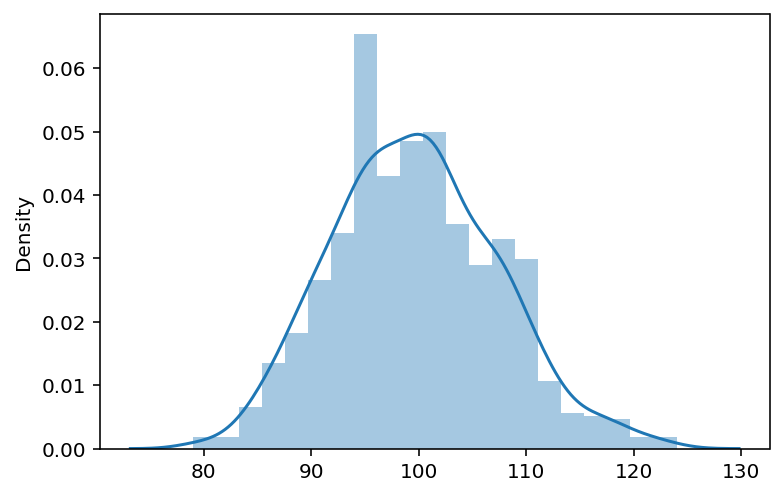

In [9]:
demand_samples = stats.poisson(60, 40).rvs(1000)
sns.distplot(demand_samples);

We can evaluate our objective function over every demand we observed historically (setting engines in stock to `100`):

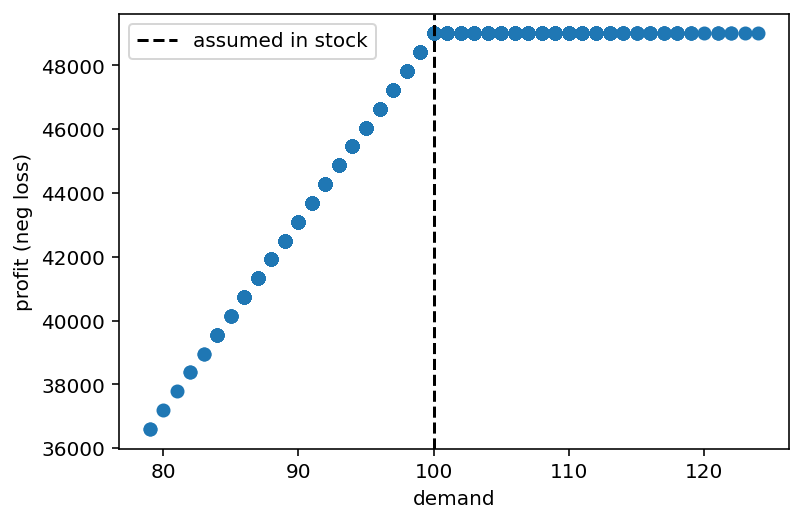

In [10]:
plt.scatter(demand_samples, -loss(in_stock=100, demand=demand_samples, buy_price=10))
plt.xlabel('demand'); plt.ylabel('profit (neg loss)'); plt.axvline(100, c='k', ls='--', label='assumed in stock');
plt.legend();

In response to demand, the loss-function behaves differently: with less demand than what we have in stock, we earn less (because we sell fewer launches but also have to pay holding costs), but as demand exceeds the number of engines we have in stock our profit stays flat because we can't sell more than what we have.

## Estimating yield with a Bayesian model

Let's use [`PyMC3`](http://pymc.io) to build a model to estimate the yield of every engine supplier:

In [11]:
with pm.Model() as model:
    # Priors on alpha and beta parameters for each supplier
    α = pm.HalfNormal('α', sd=10., shape=3) + 1
    β = pm.HalfNormal('β', sd=10., shape=3) + 1
    
    # Different likelihood for every supplier because we have different
    # number of data points
    for i, d in enumerate(data):
        pm.Beta(f'supplier_yield_obs_{i}', 
            alpha=α[i], beta=β[i],
            observed=d)
    
    trace = pm.sample()

/Users/twiecki/projects/pymc/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β, α]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 23 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


/Users/twiecki/miniconda3/envs/pymc3theano/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


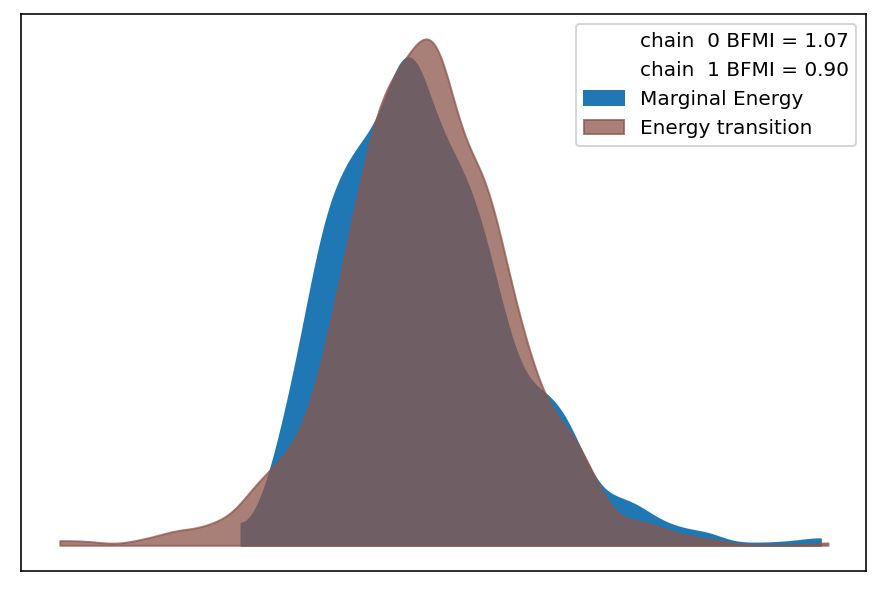

In [12]:
# make sure convergence looks good
az.plot_energy(trace);

## Generate possible future scenarios

In order to perform Bayesian Decision Making we need an estimate of what the future might look like. As we are in a generative framework this is trivial: we just need to sample from the [posterior predictive distribution](https://en.wikipedia.org/wiki/Posterior_predictive_distribution) of our model which generates new data based on our estimated posteriors.

In [13]:
with model:
    post_pred = pm.sample_posterior_predictive(trace, 1000)

/Users/twiecki/projects/pymc/pymc3/sampling.py:1688: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


/Users/twiecki/miniconda3/envs/pymc3theano/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


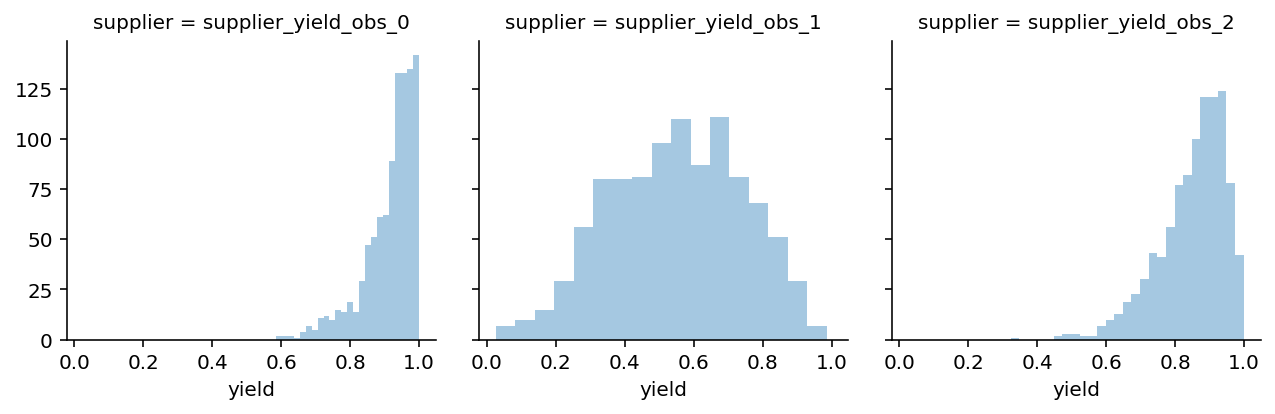

In [14]:
supplier_yield_post_pred = pd.DataFrame({k: v[:, 1] for k, v in post_pred.items()})
data_tidy = supplier_yield_post_pred.unstack().to_frame('yield')
data_tidy.index = data_tidy.index.set_names(['supplier', 'obs'])
g = sns.FacetGrid(data=data_tidy.reset_index().dropna(), col='supplier')
g.map(sns.distplot, 'yield', kde=False);

This plot shows, given the data and our model, what we can expect to observe. Note that these predictions take the uncertainty into account. For supplier 2 we have a lot of uncertainty because we only observed very few data points.

Given these estimates we can write a function that converts the orders we place to each supplier, the yield we assume for each one, and what their prices are.

In [15]:
def calc_yield_and_price(orders, 
                         supplier_yield=np.array([.9, .5, .8]),
                         prices=PRICES
                        ):
    orders = np.asarray(orders)
    
    full_yield = np.sum(supplier_yield * orders)
    price_per_item = np.sum(orders * prices) / np.sum(orders)
    
    return full_yield, price_per_item

calc_yield_and_price([100, 60, 60])

(168.0, 160.0)

So given these (randomly picked) order amounts to each supplier and some deterministic yield, we would receive 168 functioning engines at an effective price of 160 BTC each.

## Bayesian Decision Making

Now we have to actually do the optimization. First, we need to specify our objective function which will compute the total yield and effective price given a posterior predictive sample. Once we have that and our demand (also a sample from that distribution), we can compute our loss. As we have a distribution over possible scenarios, we compute the loss for each one and return the distribution.

In [16]:
def objective(orders, supplier_yield=supplier_yield_post_pred,
              demand_samples=demand_samples, max_order_size=MAX_ORDER_SIZE):
    orders = np.asarray(orders)
    losses = []
    
    # Negative orders are impossible, indicated by np.inf
    if np.any(orders < 0):
        return np.inf
    # Ordering more than the supplier can ship is also impossible
    if np.any(orders > MAX_ORDER_SIZE):
        return np.inf
    
    # Iterate over post pred samples provided in supplier_yield
    for i, supplier_yield_sample in supplier_yield.iterrows():
        full_yield, price_per_item = calc_yield_and_price(
            orders,
            supplier_yield=supplier_yield_sample
        )
        
        # evaluate loss over each sample with one sample from the demand distribution
        loss_i = loss(full_yield, demand_samples[i], price_per_item)
        
        losses.append(loss_i)
        
    return np.asarray(losses)

Great, we have all our required functions, let's put things into an optimizer and see what happens.

In [17]:
from scipy import optimize

In [18]:
# parameters for the optimization, we're just including the max order sizes as bounds
bounds = [(0, max_order) for max_order in MAX_ORDER_SIZE]
starting_value = [50., 50., 50.]

In [19]:
# minimize the expected loss under all possible scenarios
opt_stoch = optimize.minimize(lambda *args: np.mean(objective(*args)), 
                              starting_value, 
                              bounds=bounds)

In [20]:
print('Optimal order amount from every supplier = {}'.format(np.ceil(opt_stoch.x)))

Optimal order amount from every supplier = [ 0. 55. 96.]


In [21]:
print('Total order amount from all suppliers = {}'.format(np.ceil(np.sum(opt_stoch.x))))

Total order amount from all suppliers = 150.0


Great, we did it! Excitedly you go to your manager and tell her the amazing model you built and the optimal order amounts. Unfortunately, she is not impressed and asks "that's some fancy technique, but I'm not convinced this is actually better than what we currently use which is to just take the means of the yield distribution for each supplier."

## Evaluation

Slightly discouraged you go back to your desk and wonder why life is so unfair and you actually have to prove that things work and why "but it's Bayesian!" is not as convincing an argument as you hoped for. After some deep reflection you come to the conclusion that your manager might have a point and that additional complexity must be warranted and demonstrably better. To build a more compelling case, you decide to compare the naive method of just using the means to your fancy method in terms of expected profit in a simulation study.

Instead of samples from the posterior predictive, we can just pass a single sample -- the mean -- into our objective function.

In [22]:
supplier_yield_mean = pd.DataFrame([np.mean(d) for d in data]).T
supplier_yield_mean

,0,1,2
0,0.918735,0.558903,0.896244


As well as the demand we expect on average (`100`). This way we can still use the above objective function but the loop will just run once. 

In [23]:
opt_non_stoch = optimize.minimize(lambda *args: objective(*args, 
                                                          supplier_yield=supplier_yield_mean, 
                                                          demand_samples=[100]), 
                                  starting_value, 
                                  bounds=bounds)

In [24]:
print('Optimal order amount from every supplier = {}'.format(np.ceil(opt_non_stoch.x)))

Optimal order amount from every supplier = [42. 46. 42.]


In [25]:
print('Total order amount from all suppliers = {}'.format(np.ceil(np.sum(opt_non_stoch.x))))

Total order amount from all suppliers = 128.0


The results are certainly different. The full Bayesian treatment seems to dislike our high-cost but high-quality supplier. It also orders more in total (probably to account for the lower yield of the other two suppliers). But which one is actually better in terms of our profit?

To answer that question, we will generate new data from our true generative model and compute the profit in each new scenario given the order amounts from the two optimizations.

In [26]:
np.random.seed(123)
data_new = []
for supplier_yield, supplier_yield_sd, n_obs in zip(SUPPLIER_YIELD, SUPPLIER_YIELD_SD, N_OBS):
    data_new.append(pm.Beta.dist(mu=supplier_yield, sd=supplier_yield_sd, shape=1000).random())
data_new = pd.DataFrame(data_new).T
data_new.head().add_prefix("Supplier ")

,Supplier 0,Supplier 1,Supplier 2
0,0.880298,0.752686,0.997934
1,0.698046,0.307304,0.971085
2,0.676807,0.534287,0.891209
3,0.943773,0.666368,0.975907
4,0.911538,0.457898,0.556483


/Users/twiecki/miniconda3/envs/pymc3theano/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


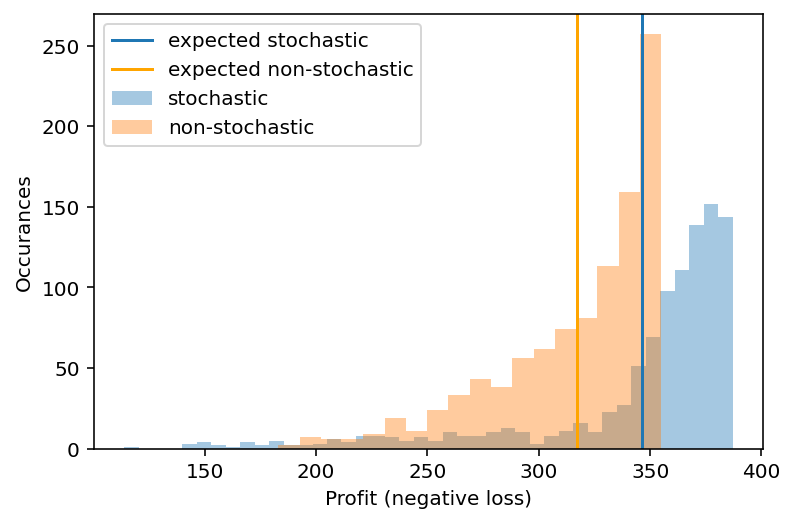

In [27]:
neg_loss_stoch = -objective(opt_stoch.x, supplier_yield=data_new) / demand_samples
neg_loss_non_stoch = -objective(opt_non_stoch.x, supplier_yield=data_new) / demand_samples
sns.distplot(neg_loss_stoch, label='stochastic', kde=False)
plt.axvline(np.mean(neg_loss_stoch), label='expected stochastic')
sns.distplot(neg_loss_non_stoch, label='non-stochastic', kde=False)
plt.axvline(np.mean(neg_loss_non_stoch), color='orange', label='expected non-stochastic')
plt.legend(); plt.xlabel('Profit (negative loss)'); plt.ylabel('Occurances');

In [31]:
print('Expected profit of Bayesian model = %.2f BTC' % np.mean(neg_loss_stoch))
print('Expected profit of naive model = %.2f BTC' % np.mean(neg_loss_non_stoch))
print('Expected value of including uncertainty = %.2f BTC' % (np.mean(neg_loss_stoch) - np.mean(neg_loss_non_stoch)))

Expected profit of Bayesian model = 346.32 BTC
Expected profit of naive model = 317.01 BTC
Expected value of including uncertainty = 29.31 BTC


Your manager is very pleased that you finally speak her language and demonstrated an expected 10% increase in profit, which translates to millions of additional profit over a year at the scale the spaceport operates on. For your demonstrated ability to understand business requirements you get promoted to Chief Bayesian Officer.

## Summary

As you can see, once we have a Bayesian model and an objective function we can apply Bayesian Decision Theory to make better decisions. Why better? While there is a [mathematical proof](http://www.ee.columbia.edu/~vittorio/BayesProof.pdf) that shows this to be optimal, there are also more practical and intuitive reasons. The first major reason is that we do not just optimize over the most likely future scenario, but *all* possible future scenarios. 

In addition, as we did the optimization just using samples rather probability distributions we don't have to do any integration (see [this great blog post](http://www.statsathome.com/2017/10/12/bayesian-decision-theory-made-ridiculously-simple/) for an introduction). This gives us huge flexibility in our approach as we can arbitrarily extend our models but still use the same framework. For example, we could use the [Prophet](https://github.com/luke14free/pm-prophet) forecasting model to forecast demand more accurately. Or we could extend our yield estimation model to be hierarchical. If you want to play around with this, you can [download the notebook](https://github.com/twiecki/WhileMyMCMCGentlySamples/blob/master/content/downloads/notebooks/supply_chain.ipynb).

## Acknowledgements

Thanks to [Peadar Coyle](https://twitter.com/Springcoil) for useful feedback on an earlier draft. Also thanks to the [Patreon supporters](https://www.patreon.com/twiecki), specifically [Jonathan Ng](https://twitter.com/_jonathanng_) and [Richard Craib](https://twitter.com/richardcraib). If you enjoyed this post, please consider supporting me on [Patreon](https://www.patreon.com/twiecki).

Finally, thanks to [Ravin Kumar](https://twitter.com/canyon289) who teamed up with me to write this blog post. He used to optimize supply chains at SpaceX so he helped a lot with making sure our examples are actually relevant. He also has an [amazing blog](http://canyon289.github.io/). 